In [1]:
# char_rnn_part1.py
# Character-level RNN Language Model - Part 1: Data Processing
# PyTorch implementation of Andrej Karpathy's char-rnn in Python

import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import math
import random
from pathlib import Path
from typing import Dict, List, Tuple, Union, Optional

class TextDataset:
    """
    Dataset class for loading and preprocessing text files
    """
    def __init__(self, data_dir: str, seq_length: int, batch_size: int, split_fractions: List[float] = [0.9, 0.05, 0.05]):
        """
        Initialization

        Args:
            data_dir: Directory containing the input.txt file
            seq_length: Length of each sequence
            batch_size: Batch size
            split_fractions: Split ratios for training, validation, and test sets
        """
        self.data_dir = Path(data_dir)
        self.seq_length = seq_length
        self.batch_size = batch_size

        # Check if the split ratios are valid
        assert sum(split_fractions) <= 1.0, "The sum of split fractions must be less than or equal to 1.0"
        self.split_fractions = split_fractions

        input_file = self.data_dir / 'input.txt'
        vocab_file = self.data_dir / 'vocab.pt'
        tensor_file = self.data_dir / 'data.pt'

        # Ensure the data directory exists
        os.makedirs(self.data_dir, exist_ok=True)

        # Check if preprocessing is needed
        run_prepro = False
        if not (vocab_file.exists() and tensor_file.exists()):
            print('vocab.pt and data.pt do not exist. Preprocessing...')
            run_prepro = True
        elif input_file.exists():
            # Check if the input file is more recent than the vocabulary file
            input_time = os.path.getmtime(input_file)
            vocab_time = os.path.getmtime(vocab_file)
            tensor_time = os.path.getmtime(tensor_file)
            if input_time > vocab_time or input_time > tensor_time:
                print('vocab.pt or data.pt is outdated. Reprocessing...')
                run_prepro = True

        if run_prepro and input_file.exists():
            # Preprocess the input text file
            print(f'One-time setup: Preprocessing input text file {input_file}...')
            self.text_to_tensor(input_file, vocab_file, tensor_file)
        elif not input_file.exists():
            raise FileNotFoundError(f"Input file {input_file} does not exist")

        print('Loading data files...')
        self.data = torch.load(tensor_file)
        self.vocab_mapping = torch.load(vocab_file)

        # Reverse mapping (index -> character)
        self.inv_vocab_mapping = {idx: char for char, idx in self.vocab_mapping.items()}

        # Ensure data is divisible by batch_size * seq_length
        data_len = len(self.data)
        if data_len % (batch_size * seq_length) != 0:
            print('Truncating data to ensure even batch/sequence division')
            # Truncate data to make it evenly divisible by batch_size * seq_length
            trim_len = (data_len // (batch_size * seq_length)) * batch_size * seq_length
            self.data = self.data[:trim_len]

        # Compute vocabulary size
        self.vocab_size = len(self.vocab_mapping)
        print(f'Vocabulary size: {self.vocab_size}')

        # Create batches
        self.prepare_batches()

        # Initialize batch pointers
        self.batch_idx = {i: 0 for i in range(3)}  # train:0, val:1, test:2

    def text_to_tensor(self, in_textfile: Path, out_vocabfile: Path, out_tensorfile: Path) -> None:
        """
        Convert a text file to a tensor and save the vocabulary

        Args:
            in_textfile: Path to the input text file
            out_vocabfile: Path to the output vocabulary file
            out_tensorfile: Path to the output tensor file
        """
        with open(in_textfile, 'r', encoding='utf-8') as f:
            text = f.read()

        # Create vocabulary mapping (character -> index)
        print('Creating vocabulary mapping...')
        chars = sorted(list(set(text)))
        vocab_mapping = {char: i for i, char in enumerate(chars)}

        # Convert text to tensor
        print('Converting data to tensor...')
        data = torch.LongTensor([vocab_mapping[char] for char in text])

        # Save preprocessed files
        print(f'Saving {out_vocabfile}')
        torch.save(vocab_mapping, out_vocabfile)
        print(f'Saving {out_tensorfile}')
        torch.save(data, out_tensorfile)

    def prepare_batches(self) -> None:
        """
        Prepare batches for training
        """
        # Reshape data to (batch_size, n)
        data_len = len(self.data)
        self.num_batches = data_len // (self.batch_size * self.seq_length)

        # Reshape to (batch_size, -1)
        xdata = self.data.view(self.batch_size, -1)
        # Create y data, a shifted copy of x
        ydata = xdata.clone()
        ydata[:, :-1] = xdata[:, 1:]
        ydata[:, -1] = xdata[:, 0]

        # Split data into chunks of seq_length
        self.x_batches = []
        self.y_batches = []
        for i in range(0, xdata.size(1), self.seq_length):
            if i + self.seq_length <= xdata.size(1):
                self.x_batches.append(xdata[:, i:i + self.seq_length])
                self.y_batches.append(ydata[:, i:i + self.seq_length])

        # Ensure the number of x and y batches match
        assert len(self.x_batches) == len(self.y_batches)

        # Compute training/validation/test split sizes
        self.num_train = int(len(self.x_batches) * self.split_fractions[0])
        self.num_val = int(len(self.x_batches) * self.split_fractions[1])
        self.num_test = len(self.x_batches) - self.num_train - self.num_val

        self.split_sizes = [self.num_train, self.num_val, self.num_test]

        print(f'Data loading complete. Training batches: {self.num_train}, Validation: {self.num_val}, Test: {self.num_test}')

    def reset_batch_pointer(self, split_index: int, batch_index: int = 0) -> None:
        """
        Reset batch pointer for a given split

        Args:
            split_index: Split index (0: training, 1: validation, 2: test)
            batch_index: Batch index, default is 0
        """
        self.batch_idx[split_index] = batch_index

    def next_batch(self, split_index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Get the next batch

        Args:
            split_index: Split index (0: training, 1: validation, 2: test)

        Returns:
            (x_batch, y_batch): Input and target batches
        """
        if self.split_sizes[split_index] == 0:
            split_names = ['train', 'val', 'test']
            raise ValueError(f'Error: Requested batch for split {split_names[split_index]}, but this split has no data.')

        # Update batch pointer
        idx = self.batch_idx[split_index]
        self.batch_idx[split_index] = (idx + 1) % self.split_sizes[split_index]

        # Compute actual index
        if split_index == 1:  # Validation set
            idx += self.num_train
        elif split_index == 2:  # Test set
            idx += self.num_train + self.num_val

        return self.x_batches[idx], self.y_batches[idx]


In [2]:
# char_rnn_part2.py
# Character-level RNN Language Model - Part 2: Model Definition
# PyTorch implementation of Andrej Karpathy's char-rnn in Python

import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict, List, Tuple, Union, Optional

class CharRNN(nn.Module):
    """
    Character-level RNN Language Model
    """
    def __init__(self, vocab_size: int, input_size: int, hidden_size: int, num_layers: int,
                model_type: str = 'lstm', dropout: float = 0.0):
        """
        Initialize the CharRNN model

        Args:
            vocab_size: Vocabulary size
            input_size: Input size for one-hot encoding (usually equal to vocab_size)
            hidden_size: Hidden layer size
            num_layers: Number of RNN layers
            model_type: Type of RNN ('rnn', 'lstm', or 'gru')
            dropout: Dropout probability
        """
        super(CharRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.model_type = model_type.lower()
        self.dropout = dropout

        # Embedding layer
        self.encoder = nn.Embedding(vocab_size, input_size)

        # Select RNN type
        if self.model_type == 'lstm':
            self.rnn = nn.LSTM(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        elif self.model_type == 'gru':
            self.rnn = nn.GRU(input_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        elif self.model_type == 'rnn':
            self.rnn = nn.RNN(input_size, hidden_size, num_layers, nonlinearity='tanh', dropout=dropout, batch_first=True)
        else:
            raise ValueError(f"Unknown RNN type: {self.model_type}. Must be 'rnn', 'lstm', or 'gru'")

        # Decoder (converts to output size)
        self.decoder = nn.Linear(hidden_size, vocab_size)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        """
        Initialize weights
        """
        # Initialize embedding weights
        init_range = 0.1
        self.encoder.weight.data.uniform_(-init_range, init_range)

        # Initialize decoder weights
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-init_range, init_range)

        # If LSTM, initialize forget gate bias to 1
        if self.model_type == 'lstm':
            for names in self.rnn._all_weights:
                for name in filter(lambda n: "bias" in n, names):
                    bias = getattr(self.rnn, name)
                    n = bias.size(0)
                    start, end = n // 4, n // 2
                    bias.data[start:end].fill_(1.0)

    def init_hidden(self, batch_size: int, device: torch.device) -> Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        """
        Initialize hidden state

        Args:
            batch_size: Batch size
            device: Computing device

        Returns:
            Initialized hidden state
        """
        weight = next(self.parameters())
        if self.model_type == 'lstm':
            return (weight.new_zeros(self.num_layers, batch_size, self.hidden_size).to(device),
                    weight.new_zeros(self.num_layers, batch_size, self.hidden_size).to(device))
        else:
            return weight.new_zeros(self.num_layers, batch_size, self.hidden_size).to(device)

    def forward(self, input: torch.Tensor, hidden: Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]) -> Tuple[torch.Tensor, Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]]:
        """
        Forward propagation

        Args:
            input: Input sequence [batch_size, seq_length]
            hidden: Initial hidden state

        Returns:
            output: Output sequence [batch_size, seq_length, vocab_size]
            hidden: Final hidden state
        """
        # Embed input
        emb = self.encoder(input)  # [batch_size, seq_length, input_size]

        # Run RNN
        output, hidden = self.rnn(emb, hidden)  # [batch_size, seq_length, hidden_size], hidden_state

        # Decode output
        decoded = self.decoder(output)  # [batch_size, seq_length, vocab_size]

        return decoded, hidden

    def forward_step(self, input: torch.Tensor, hidden: Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]) -> Tuple[torch.Tensor, Union[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]]:
        """
        Single-step forward propagation for text generation

        Args:
            input: Single input [batch_size, 1]
            hidden: Hidden state

        Returns:
            output: Output [batch_size, vocab_size]
            hidden: Updated hidden state
        """
        # Embed input
        emb = self.encoder(input)  # [batch_size, 1, input_size]

        # Run RNN
        output, hidden = self.rnn(emb, hidden)  # [batch_size, 1, hidden_size], hidden_state

        # Decode output
        decoded = self.decoder(output.squeeze(1))  # [batch_size, vocab_size]

        return F.log_softmax(decoded, dim=1), hidden


In [3]:
# char_rnn_part3.py
# Character-level RNN Language Model - Part 3: Training and Evaluation Functions
# PyTorch implementation of Andrej Karpathy's char-rnn in Python

import torch
import torch.nn as nn
import torch.optim as optim
import time
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Dict, List, Tuple, Union, Optional
import math
import numpy as np

# Ensure necessary classes are imported from Part 1 and Part 2
# from char_rnn_part1 import TextDataset
# from char_rnn_part2 import CharRNN

def train(model: nn.Module, data_loader, optimizer: torch.optim.Optimizer,
         criterion: nn.Module, device: torch.device,
         grad_clip: float = 5.0, print_every: int = 100) -> float:
    """
    Train for one epoch

    Args:
        model: The model
        data_loader: Data loader
        optimizer: Optimizer
        criterion: Loss function
        device: Computing device
        grad_clip: Gradient clipping value
        print_every: Print progress every N batches

    Returns:
        Average loss
    """
    model.train()
    data_loader.reset_batch_pointer(0)  # Reset training pointer
    total_loss = 0
    start_time = time.time()

    # Initialize hidden state
    hidden = model.init_hidden(data_loader.batch_size, device)

    for i in range(data_loader.num_train):
        # Get batch
        x, y = data_loader.next_batch(0)  # Get training batch

        # Move to device
        x = x.to(device)
        y = y.to(device)

        # Detach hidden state
        if isinstance(hidden, tuple):
            hidden = tuple(h.detach() for h in hidden)
        else:
            hidden = hidden.detach()

        # Forward pass
        output, hidden = model(x, hidden)

        # Compute loss
        loss = criterion(output.view(-1, data_loader.vocab_size), y.view(-1))

        # Backward pass
        optimizer.zero_grad()
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        # Update parameters
        optimizer.step()

        # Record loss
        total_loss += loss.item()

        # Print progress
        if (i + 1) % print_every == 0:
            elapsed = time.time() - start_time
            print(f'| Batch {i + 1}/{data_loader.num_train} | '
                  f'Time {elapsed:.2f}s | Loss {loss.item():.4f}')
            start_time = time.time()

    return total_loss / data_loader.num_train

def evaluate(model: nn.Module, data_loader, criterion: nn.Module,
           device: torch.device, split_index: int) -> float:
    """
    Evaluate the model

    Args:
        model: The model
        data_loader: Data loader
        criterion: Loss function
        device: Computing device
        split_index: Split index (1: validation, 2: test)

    Returns:
        Average loss
    """
    model.eval()
    data_loader.reset_batch_pointer(split_index)  # Reset validation/test pointer
    total_loss = 0
    num_batches = data_loader.split_sizes[split_index]

    # Initialize hidden state
    hidden = model.init_hidden(data_loader.batch_size, device)

    with torch.no_grad():
        for i in range(num_batches):
            # Get batch
            x, y = data_loader.next_batch(split_index)

            # Move to device
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            output, hidden = model(x, hidden)

            # Compute loss
            loss = criterion(output.view(-1, data_loader.vocab_size), y.view(-1))

            # Record loss
            total_loss += loss.item()

    return total_loss / num_batches

def generate(model: nn.Module, data_loader, prime_text: str,
             length: int, temperature: float, device: torch.device, topk: int = 0) -> str:
    """
    Generate text using the model

    Args:
        model: Trained model
        data_loader: Data loader (for vocabulary mapping)
        prime_text: Seed text
        length: Length of the generated text
        temperature: Sampling temperature
        device: Computing device
        topk: Use top-k sampling (0 to disable)

    Returns:
        Generated text
    """
    model.eval()
    vocab_mapping = data_loader.vocab_mapping
    inv_vocab_mapping = data_loader.inv_vocab_mapping

    # Convert prime_text to index list
    prime_idxs = [vocab_mapping.get(char, vocab_mapping.get(' ')) for char in prime_text]

    # Initialize hidden state
    hidden = model.init_hidden(1, device)

    # Warm up the model
    with torch.no_grad():
        for p in prime_idxs[:-1]:
            input_tensor = torch.tensor([[p]], dtype=torch.long).to(device)
            _, hidden = model.forward_step(input_tensor, hidden)

        # Last character
        prev_char = torch.tensor([[prime_idxs[-1]]], dtype=torch.long).to(device)

        # Generated result text, starting with prime_text
        result_text = prime_text

        # Start generation
        for i in range(length):
            # Single forward step
            output, hidden = model.forward_step(prev_char, hidden)

            # Apply temperature
            output = output.div(temperature)
            output = torch.exp(output)

            # Optional: top-k sampling
            if topk > 0:
                topk = min(topk, output.size(-1))
                top_v, top_idx = torch.topk(output, topk)
                probs = top_v / top_v.sum()
                # Sample from top-k
                idx = torch.multinomial(probs, 1)
                prev_char = top_idx[:, idx.item()].view(1, 1)
            else:
                # Standard sampling
                probs = output / output.sum()
                prev_char = torch.multinomial(probs, 1)

            # Convert to character and add to result
            char = inv_vocab_mapping[prev_char.item()]
            result_text += char

    return result_text


In [4]:
# char_rnn_part4.py
# Character-level RNN Language Model - Part 4: Main Training Loop and Utility Tools
# PyTorch implementation of Andrej Karpathy's char-rnn in Python

import os
import torch
import torch.nn as nn
import torch.optim as optim
import argparse
import matplotlib.pyplot as plt
from pathlib import Path
import time
import json
import random
import numpy as np
from typing import Dict, List, Tuple, Union, Optional

# Ensure necessary functions are imported from previous parts
# from char_rnn_part1 import TextDataset
# from char_rnn_part2 import CharRNN
# from char_rnn_part3 import train, evaluate, generate

def train_model(data_dir: str, model_type: str = 'lstm', hidden_size: int = 128,
               num_layers: int = 2, dropout: float = 0.0, seq_length: int = 50,
               batch_size: int = 50, max_epochs: int = 50, learning_rate: float = 0.002,
               lr_decay: float = 0.97, lr_decay_after: int = 10, grad_clip: float = 5.0,
               checkpoint_dir: str = 'checkpoints'):
    """
    Train a character-level RNN language model

    Args:
        data_dir: Directory containing input.txt file
        model_type: Type of RNN ('rnn', 'lstm', or 'gru')
        hidden_size: Size of the hidden layer
        num_layers: Number of RNN layers
        dropout: Dropout probability
        seq_length: Sequence length
        batch_size: Batch size
        max_epochs: Maximum number of epochs
        learning_rate: Learning rate
        lr_decay: Learning rate decay factor
        lr_decay_after: Number of epochs before learning rate starts decaying
        grad_clip: Gradient clipping value
        checkpoint_dir: Directory for saving checkpoints
    """
    # Create the save directory
    checkpoint_path = Path(checkpoint_dir)
    checkpoint_path.mkdir(exist_ok=True)

    # Check CUDA availability
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f'Using device: {device}')

    # Load dataset
    data_loader = TextDataset(data_dir, seq_length, batch_size)

    # Create model
    vocab_size = data_loader.vocab_size
    embedding_size = hidden_size  # Embedding size equals hidden size
    model = CharRNN(vocab_size, embedding_size, hidden_size, num_layers, model_type, dropout)
    model.to(device)

    # Create optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # Print number of model parameters
    params = sum([p.numel() for p in model.parameters()])
    print(f'Total model parameters: {params}')

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=lr_decay)

    # Save training and validation loss
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    # Training loop
    for epoch in range(max_epochs):
        print(f'Epoch {epoch + 1}/{max_epochs}')
        print('-' * 20)

        # Training
        train_loss = train(model, data_loader, optimizer, criterion, device, grad_clip)
        train_losses.append(train_loss)

        # Validation
        val_loss = evaluate(model, data_loader, criterion, device, 1)
        val_losses.append(val_loss)

        print(f'Training Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}')

        # Learning rate decay
        if epoch >= lr_decay_after:
            scheduler.step()
            print(f'Learning rate decayed to: {optimizer.param_groups[0]["lr"]:.6f}')

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            checkpoint = {
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'vocab_mapping': data_loader.vocab_mapping,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'params': {
                    'model_type': model_type,
                    'hidden_size': hidden_size,
                    'num_layers': num_layers,
                    'vocab_size': vocab_size,
                    'embedding_size': embedding_size,
                    'dropout': dropout
                }
            }

            model_filename = f'{model_type}_epoch{epoch+1:02d}_val{val_loss:.4f}.pt'
            save_path = checkpoint_path / model_filename
            torch.save(checkpoint, save_path)
            print(f'Saved model to {save_path}')

        print()

    # Plot training and validation loss curve
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.savefig(checkpoint_path / 'loss_curve.png')
    plt.show()

    return model, data_loader

def load_model(checkpoint_path: str) -> Tuple[nn.Module, Dict]:
    """
    Load a trained model

    Args:
        checkpoint_path: Path to the checkpoint file

    Returns:
        model: Loaded model
        vocab_mapping: Vocabulary mapping
    """
    # Check if GPU is available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Retrieve model parameters
    params = checkpoint['params']
    model_type = params['model_type']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    vocab_size = params['vocab_size']
    embedding_size = params['embedding_size']
    dropout = params['dropout']

    # Create model
    model = CharRNN(vocab_size, embedding_size, hidden_size, num_layers, model_type, dropout)
    model.load_state_dict(checkpoint['model_state'])
    model.to(device)
    model.eval()

    # Retrieve vocabulary mapping
    vocab_mapping = checkpoint['vocab_mapping']

    return model, vocab_mapping

def sample_text(model_path: str, prime_text: str = '', length: int = 1000,
               temperature: float = 1.0, data_dir: str = None, topk: int = 0):
    """
    Generate text from a trained model

    Args:
        model_path: Path to the model file
        prime_text: Seed text
        length: Length of generated text
        temperature: Sampling temperature
        data_dir: Data directory (if model is not preloaded)
        topk: Use top-k sampling (0 to disable)

    Returns:
        Generated text
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load model
    checkpoint = torch.load(model_path, map_location=device)

    # Retrieve model parameters
    params = checkpoint['params']
    model_type = params['model_type']
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    vocab_size = params['vocab_size']
    embedding_size = params['embedding_size']
    dropout = params['dropout']

    # Create model
    model = CharRNN(vocab_size, embedding_size, hidden_size, num_layers, model_type, dropout)
    model.load_state_dict(checkpoint['model_state'])
    model.to(device)
    model.eval()

    # Retrieve vocabulary mapping
    vocab_mapping = checkpoint['vocab_mapping']

    # Create reverse mapping (index -> character)
    inv_vocab_mapping = {idx: char for char, idx in vocab_mapping.items()}

    # If data_dir is not provided, create a temporary data loader for sampling
    class TempDataLoader:
        def __init__(self, vocab_mapping, inv_vocab_mapping):
            self.vocab_mapping = vocab_mapping
            self.inv_vocab_mapping = inv_vocab_mapping
            self.vocab_size = len(vocab_mapping)

    data_loader = TempDataLoader(vocab_mapping, inv_vocab_mapping)

    # Generate text
    generated_text = generate(model, data_loader, prime_text, length, temperature, device, topk)

    return generated_text

def main():
    parser = argparse.ArgumentParser(description='Character-level RNN Language Model')

    # Define mode
    parser.add_argument('--mode', type=str, default='train', choices=['train', 'sample'],
                      help='Operation mode: train or sample')

    # Training parameters...
    # (Arguments remain unchanged)

    args = parser.parse_args()

    if args.mode == 'train':
        train_model(**vars(args))
    elif args.mode == 'sample':
        text = sample_text(**vars(args))
        print("=" * 80)
        print(f"Generated Text (Temperature={args.temperature}):")
        print("-" * 80)
        print(text)
        print("=" * 80)

if __name__ == "__main__":
    main()


usage: ipykernel_launcher.py [-h] [--mode {train,sample}]
ipykernel_launcher.py: error: unrecognized arguments: -f /home/miz030/.local/share/jupyter/runtime/kernel-469fdffd-2bc9-44d7-9b21-075a1524884d.json


SystemExit: 2

/opt/conda/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [5]:
# Define a training function that allows you to specify a custom name for saving the model
def train_with_config(data_dir, model_name, custom_save_name=None, model_type='lstm',
                     hidden_size=256, num_layers=2, dropout=0.3, seq_length=100, batch_size=32):
    # Use the custom name if provided, otherwise use the model_name
    save_name = custom_save_name if custom_save_name else model_name
    checkpoint_dir = f'checkpoints_{save_name}'

    model, data_loader = train_model(
        data_dir=data_dir,
        model_type=model_type,
        hidden_size=hidden_size,
        num_layers=num_layers,
        dropout=dropout,
        seq_length=seq_length,
        batch_size=batch_size,
        max_epochs=30,
        learning_rate=0.002,
        lr_decay=0.97,
        lr_decay_after=10,
        grad_clip=5.0,
        checkpoint_dir=checkpoint_dir
    )

    # After training, you can rename the checkpoint file if needed
    import glob
    import os
    checkpoint_files = glob.glob(f'{checkpoint_dir}/*.pt')
    if checkpoint_files:
        best_checkpoint = min(checkpoint_files,
                             key=lambda x: float(x.split('val')[-1].split('.pt')[0]))

        # Create a new filename with your custom name
        new_filename = os.path.join(checkpoint_dir,
                                   f"{save_name}_final.pt")

        # Make a copy of the best checkpoint with the new name
        import shutil
        shutil.copy(best_checkpoint, new_filename)
        print(f"Best model saved as: {new_filename}")

    return model, data_loader



Using device: cuda
Loading data files...
Truncating data to ensure even batch/sequence division
Vocabulary size: 119
Data loading complete. Training batches: 612, Validation: 34, Test: 34
Total model parameters: 2456951
Epoch 1/30
--------------------
| Batch 100/612 | Time 1.02s | Loss 2.5979
| Batch 200/612 | Time 0.95s | Loss 2.1699
| Batch 300/612 | Time 0.95s | Loss 2.0680
| Batch 400/612 | Time 0.96s | Loss 1.8974
| Batch 500/612 | Time 0.96s | Loss 1.8124
| Batch 600/612 | Time 0.95s | Loss 1.7826
Training Loss: 2.1597 | Validation Loss: 1.7518
Saved model to checkpoints_SciFi_Adventure_Model/lstm_epoch01_val1.7518.pt

Epoch 2/30
--------------------
| Batch 100/612 | Time 0.80s | Loss 1.6793
| Batch 200/612 | Time 0.80s | Loss 1.6455
| Batch 300/612 | Time 0.80s | Loss 1.6743
| Batch 400/612 | Time 0.80s | Loss 1.6124
| Batch 500/612 | Time 0.80s | Loss 1.5737
| Batch 600/612 | Time 0.80s | Loss 1.5703
Training Loss: 1.6450 | Validation Loss: 1.5532
Saved model to checkpoints_S

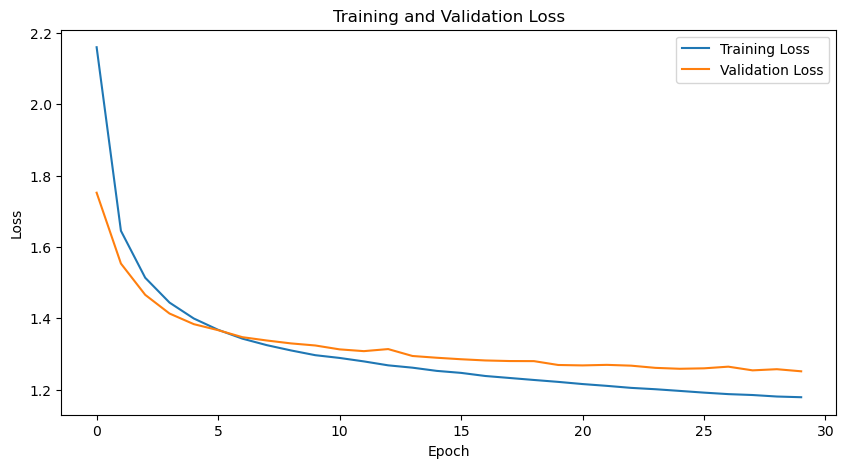

Best model saved as: checkpoints_SciFi_Adventure_Model/SciFi_Adventure_Model_final.pt


In [11]:
# Now train your models with custom names
scifi_model, scifi_loader = train_with_config(
    'data/science_fiction', 'science_fiction', custom_save_name='SciFi_Adventure_Model',
    hidden_size=384, seq_length=100, model_type='lstm')

Using device: cuda
vocab.pt and data.pt do not exist. Preprocessing...
One-time setup: Preprocessing input text file data/romance/input.txt...
Creating vocabulary mapping...
Converting data to tensor...
Saving data/romance/vocab.pt
Saving data/romance/data.pt
Loading data files...
Truncating data to ensure even batch/sequence division
Vocabulary size: 101
Data loading complete. Training batches: 1321, Validation: 73, Test: 74
Total model parameters: 1104485
Epoch 1/30
--------------------
| Batch 100/1321 | Time 0.64s | Loss 2.6400
| Batch 200/1321 | Time 0.58s | Loss 2.3559
| Batch 300/1321 | Time 0.58s | Loss 2.1269
| Batch 400/1321 | Time 0.58s | Loss 1.9333
| Batch 500/1321 | Time 0.59s | Loss 1.8879
| Batch 600/1321 | Time 0.59s | Loss 1.7412
| Batch 700/1321 | Time 0.59s | Loss 1.8127
| Batch 800/1321 | Time 0.59s | Loss 1.6846
| Batch 900/1321 | Time 0.59s | Loss 1.6546
| Batch 1000/1321 | Time 0.59s | Loss 1.6482
| Batch 1100/1321 | Time 0.59s | Loss 1.6485
| Batch 1200/1321 | 

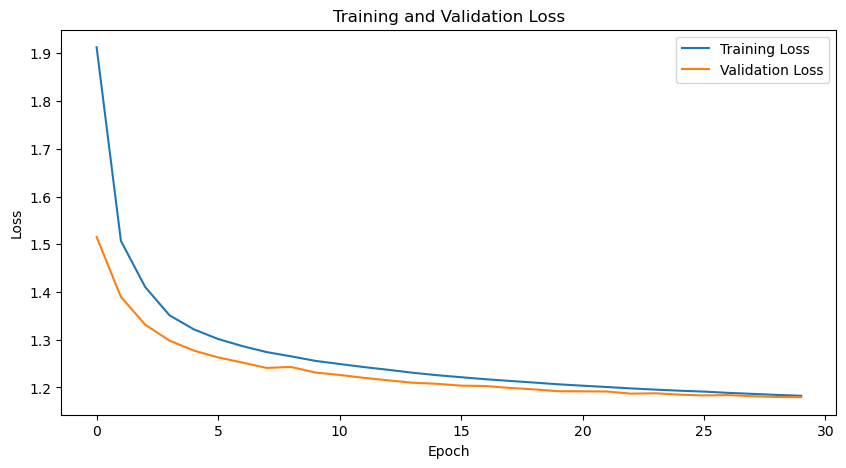

Best model saved as: checkpoints_Classic_Romance_Model/Classic_Romance_Model_final.pt


In [12]:
romance_model, romance_loader = train_with_config(
    'data/romance', 'romance', custom_save_name='Classic_Romance_Model',
    hidden_size=256, dropout=0.2, model_type='lstm')


In [ ]:
mixed_model, mixed_loader = train_with_config(
    'data/mixed', 'mixed', custom_save_name='SciFi_Romance_Hybrid',
    hidden_size=512, num_layers=3, dropout=0.4, model_type='gru')

Using device: cuda
Loading data files...
Truncating data to ensure even batch/sequence division
Vocabulary size: 123
Data loading complete. Training batches: 1934, Validation: 107, Test: 108
Total model parameters: 6429819
Epoch 1/30
--------------------
| Batch 100/1934 | Time 1.53s | Loss 3.1192
| Batch 200/1934 | Time 1.53s | Loss 2.7851
| Batch 300/1934 | Time 1.53s | Loss 2.4084
| Batch 400/1934 | Time 1.53s | Loss 2.2157
| Batch 500/1934 | Time 1.53s | Loss 2.0770
| Batch 600/1934 | Time 1.53s | Loss 1.9011
| Batch 700/1934 | Time 1.53s | Loss 1.8398
| Batch 800/1934 | Time 1.53s | Loss 1.8103
| Batch 900/1934 | Time 1.53s | Loss 1.6896
| Batch 1000/1934 | Time 1.53s | Loss 1.6753
| Batch 1100/1934 | Time 1.53s | Loss 1.6044
| Batch 1200/1934 | Time 1.53s | Loss 1.5743
| Batch 1300/1934 | Time 1.53s | Loss 1.5919
| Batch 1400/1934 | Time 1.53s | Loss 1.4744
| Batch 1500/1934 | Time 1.53s | Loss 1.4752
| Batch 1600/1934 | Time 1.53s | Loss 1.5112
| Batch 1700/1934 | Time 1.53s | L

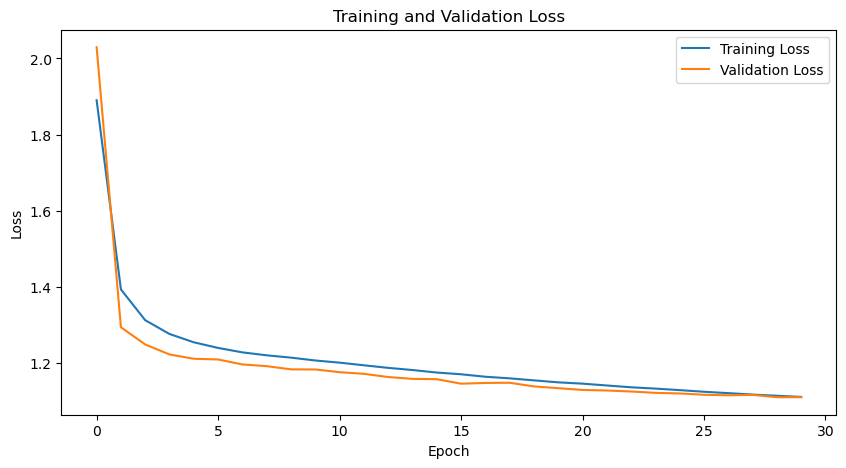

Best model saved as: checkpoints_SciFi_Romance_Hybrid/SciFi_Romance_Hybrid_final.pt


In [13]:
mixed_model, mixed_loader = train_with_config(
    'data/mixed', 'mixed', custom_save_name='SciFi_Romance_Hybrid',
    hidden_size=512, num_layers=3, dropout=0.4, model_type='lstm')

In [6]:
def generate_samples(model_name, prompts, temperature=0.8, topk=5, length=500):
    """Generate multiple text samples from a trained model"""
    import glob
    import os
    
    # Find the best checkpoint (lowest validation loss)
    checkpoint_files = glob.glob(f'checkpoints_{model_name}/*.pt')
    if not checkpoint_files:
        print(f"No checkpoint files found for {model_name}")
        return
    
    # Get the checkpoint with the lowest validation loss
    best_checkpoint = min(checkpoint_files, 
                         key=lambda x: float(x.split('val')[-1].split('.pt')[0]) 
                         if 'val' in x else float('inf'))
    
    print(f"\n===== GENERATING TEXT FROM {model_name.upper()} MODEL =====")
    print(f"Using checkpoint: {os.path.basename(best_checkpoint)}")
    
    results = []
    for i, prompt in enumerate(prompts):
        print(f"\nPrompt {i+1}: \"{prompt}\"")
        generated = sample_text(
            model_path=best_checkpoint,
            prime_text=prompt,
            length=length,
            temperature=temperature,
            topk=topk
        )
        print(f"Generated text:\n{'-'*60}\n{generated}\n{'-'*60}")
        results.append(generated)
    
    return results

In [7]:
# Define test prompts for different genres
sci_fi_prompts = [
    "The starship's engines hummed as it approached the nebula, ",
    "In the year 2150, the first quantum AI achieved consciousness and ",
    "The alien artifact glowed with an eerie blue light when "
]

romance_prompts = [
    "Her heart raced as she opened the letter, never expecting ",
    "Under the moonlit sky, their eyes met across the garden and ",
    "The duchess had sworn never to love again, but "
]

mixed_prompts = [
    "The space station's observation deck was where she first saw him, ",
    "The android felt something strange in its circuits whenever she smiled, ",
    "Time travel was forbidden, but he couldn't bear to live without her, "
]

In [8]:
# Generate text from each model
sci_fi_samples = generate_samples('SciFi_Adventure_Model', sci_fi_prompts, temperature=0.7, topk=5)
romance_samples = generate_samples('Classic_Romance_Model', romance_prompts, temperature=0.7, topk=5)
mixed_samples = generate_samples('SciFi_Romance_Hybrid', mixed_prompts, temperature=0.7, topk=5)

# Cross-genre experiment: use sci-fi prompts with romance model and vice versa
print("\n===== CROSS-GENRE EXPERIMENT =====")
sci_fi_prompts_in_romance = generate_samples('Classic_Romance_Model', sci_fi_prompts, temperature=0.8)
romance_prompts_in_scifi = generate_samples('SciFi_Adventure_Model', romance_prompts, temperature=0.8)


===== GENERATING TEXT FROM SCIFI_ADVENTURE_MODEL MODEL =====
Using checkpoint: lstm_epoch30_val1.2511.pt

Prompt 1: "The starship's engines hummed as it approached the nebula, "
Generated text:
------------------------------------------------------------
The starship's engines hummed as it approached the nebula, and
the solution of the seas of the whole waters and the
mountains of their comforts of a
few miles an immense stranger. Then I would be a little control of this partitions of the mouth of
a perfect and my companions, and that there was no
complex to the steam of the cases the red whom I
had seen there in the most distance, that all this was so concurred to the strangest of the same thing in
their creatures were being surprised in the crowd of the
polite with the most disappearance of a country 
------------------------------------------------------------

Prompt 2: "In the year 2150, the first quantum AI achieved consciousness and "
Generated text:
---------------------------

In [9]:
def analyze_text(text, genre_keywords=None):
    """Analyze text characteristics"""
    # Basic statistics
    word_count = len(text.split())
    sentence_count = len([s for s in text.split('.') if s.strip()])
    avg_words_per_sentence = word_count / max(1, sentence_count)
    unique_words = len(set(text.lower().split()))
    vocabulary_richness = unique_words / max(1, word_count)
    
    # Keyword matching
    keyword_counts = {}
    if genre_keywords:
        for category, words in genre_keywords.items():
            matches = sum(1 for word in words if word.lower() in text.lower())
            keyword_counts[category] = matches
    
    return {
        "word_count": word_count,
        "sentence_count": sentence_count,
        "avg_words_per_sentence": avg_words_per_sentence,
        "unique_words": unique_words,
        "vocabulary_richness": vocabulary_richness,
        "keyword_matches": keyword_counts
    }

# Define genre-specific keywords
keywords = {
    "sci_fi": ["space", "star", "galaxy", "robot", "alien", "future", "technology", 
               "quantum", "spacecraft", "planet", "artificial", "hologram"],
    "romance": ["love", "heart", "passion", "kiss", "embrace", "emotion", "desire",
                "longing", "romance", "affection", "intimate", "relationship"]
}

# Analyze samples from each model
all_results = {
    "SciFi_Model": [analyze_text(sample, keywords) for sample in sci_fi_samples],
    "Romance_Model": [analyze_text(sample, keywords) for sample in romance_samples],
    "Mixed_Model": [analyze_text(sample, keywords) for sample in mixed_samples]
}

# Print summary statistics
import pandas as pd
import numpy as np

for model, results in all_results.items():
    print(f"\n===== {model} Statistics =====")
    avg_results = {
        "Avg. Words": np.mean([r["word_count"] for r in results]),
        "Avg. Sentences": np.mean([r["sentence_count"] for r in results]),
        "Avg. Words/Sentence": np.mean([r["avg_words_per_sentence"] for r in results]),
        "Avg. Vocabulary Richness": np.mean([r["vocabulary_richness"] for r in results]),
        "Avg. Sci-Fi Keywords": np.mean([r["keyword_matches"]["sci_fi"] for r in results]),
        "Avg. Romance Keywords": np.mean([r["keyword_matches"]["romance"] for r in results])
    }
    df = pd.DataFrame([avg_results])
    print(df.round(2))


===== SciFi_Model Statistics =====
   Avg. Words  Avg. Sentences  Avg. Words/Sentence  Avg. Vocabulary Richness  \
0      106.33             2.0                53.17                      0.59   

   Avg. Sci-Fi Keywords  Avg. Romance Keywords  
0                   1.0                    0.0  

===== Romance_Model Statistics =====
   Avg. Words  Avg. Sentences  Avg. Words/Sentence  Avg. Vocabulary Richness  \
0      108.33            2.33                48.17                      0.63   

   Avg. Sci-Fi Keywords  Avg. Romance Keywords  
0                   0.0                   0.67  

===== Mixed_Model Statistics =====
   Avg. Words  Avg. Sentences  Avg. Words/Sentence  Avg. Vocabulary Richness  \
0      111.33             3.0                37.11                      0.61   

   Avg. Sci-Fi Keywords  Avg. Romance Keywords  
0                  0.33                    0.0  


In [10]:
import glob

def temperature_experiment(model_name, prompt, temperatures=[0.5, 0.7, 0.9, 1.1]):
    """Generate text with different temperature settings"""
    checkpoint_files = glob.glob(f'checkpoints_{model_name}/*.pt')
    if not checkpoint_files:
        return
    
    best_checkpoint = min(checkpoint_files, 
                         key=lambda x: float(x.split('val')[-1].split('.pt')[0]) 
                         if 'val' in x else float('inf'))
    
    print(f"\n===== TEMPERATURE EXPERIMENT: {model_name} =====")
    print(f"Prompt: \"{prompt}\"")
    
    for temp in temperatures:
        print(f"\nTemperature: {temp}")
        generated = sample_text(
            model_path=best_checkpoint,
            prime_text=prompt,
            length=300,
            temperature=temp,
            topk=0
        )
        print(f"{'-'*60}\n{generated}\n{'-'*60}")

# Run temperature experiments on each model
temperature_experiment('SciFi_Adventure_Model', "The alien signal was decoded and revealed ", 
                      temperatures=[0.5, 0.8, 1.1, 1.3])
temperature_experiment('Classic_Romance_Model', "She found his old letters in the attic, ",
                      temperatures=[0.5, 0.8, 1.1, 1.3])
temperature_experiment('SciFi_Romance_Hybrid', "The android was programmed to protect her, but it felt something more, ",
                      temperatures=[0.5, 0.8, 1.1, 1.3])


===== TEMPERATURE EXPERIMENT: SciFi_Adventure_Model =====
Prompt: "The alien signal was decoded and revealed "

Temperature: 0.5
------------------------------------------------------------
The alien signal was decoded and revealed the
trains of the insufficient departments of life.

I still could have been responsible to the strange more more than the waters of
the compass of the barrier of the working movement.

"Very well, sir, what the exact memory as I cannot feel there the news, even the mineral
sentiments in the confide
------------------------------------------------------------

Temperature: 0.8
------------------------------------------------------------
The alien signal was decoded and revealed the
darkness and
system, with all those boys and mouth! The other several
shoulds were but the resolution of the human beings, is shifting in a charming
name of our most familiarity.

And yet I see the roadway on a more constructed general depth of boats in
my heads, some I could not

In [11]:
def analyze_genre_fusion(text):
    """Analyze the fusion of genres in generated text"""
    # Count genre-specific elements
    sci_fi_elements = sum(1 for word in keywords["sci_fi"] if word.lower() in text.lower())
    romance_elements = sum(1 for word in keywords["romance"] if word.lower() in text.lower())
    
    # Analyze sentence structure
    sentences = [s.strip() for s in text.split('.') if s.strip()]
    mixed_sentences = 0
    
    for sentence in sentences:
        has_scifi = any(word in sentence.lower() for word in keywords["sci_fi"])
        has_romance = any(word in sentence.lower() for word in keywords["romance"])
        if has_scifi and has_romance:
            mixed_sentences += 1
    
    return {
        "sci_fi_elements": sci_fi_elements,
        "romance_elements": romance_elements,
        "total_sentences": len(sentences),
        "mixed_sentences": mixed_sentences,
        "genre_balance": f"{sci_fi_elements/(sci_fi_elements+romance_elements)*100:.1f}% sci-fi / {romance_elements/(sci_fi_elements+romance_elements)*100:.1f}% romance" if (sci_fi_elements+romance_elements) > 0 else "N/A"
    }

# Generate fusion texts with mixed model
fusion_prompts = [
    "The interstellar romance began when her spacecraft malfunctioned near his planet, ",
    "His programming didn't include falling in love, but when she repaired his circuits, ",
    "Traveling through time had consequences, but she was worth every paradox, "
]

fusion_results = []
for prompt in fusion_prompts:
    generated = sample_text(
        model_path=glob.glob('checkpoints_SciFi_Romance_Hybrid/*.pt')[0],
        prime_text=prompt,
        length=500,
        temperature=0.8,
        topk=5
    )
    
    analysis = analyze_genre_fusion(generated)
    fusion_results.append({
        "prompt": prompt,
        "text": generated,
        "analysis": analysis
    })

# Print fusion analysis
for result in fusion_results:
    print(f"\nPrompt: \"{result['prompt']}\"")
    print(f"Genre balance: {result['analysis']['genre_balance']}")
    print(f"Mixed sentences: {result['analysis']['mixed_sentences']}/{result['analysis']['total_sentences']} ({result['analysis']['mixed_sentences']/result['analysis']['total_sentences']*100:.1f}%)")
    print(f"Text sample:\n{'-'*60}\n{result['text'][:300]}...\n{'-'*60}")


Prompt: "The interstellar romance began when her spacecraft malfunctioned near his planet, "
Genre balance: 75.0% sci-fi / 25.0% romance
Mixed sentences: 1/7 (14.3%)
Text sample:
------------------------------------------------------------
The interstellar romance began when her spacecraft malfunctioned near his planet, which
was the conduct of the convulsive speed.

I was a smile to the part of her sister.

Her carriage had no more than herself therefore, “if they
are conscious to me,” said he, “it will be making my father of her own...
------------------------------------------------------------

Prompt: "His programming didn't include falling in love, but when she repaired his circuits, "
Genre balance: 0.0% sci-fi / 100.0% romance
Mixed sentences: 0/5 (0.0%)
Text sample:
------------------------------------------------------------
His programming didn't include falling in love, but when she repaired his circuits, a
distinct carriage and manner that was to be a good deal of
passion

In [20]:
import math
import torch
import glob
from nltk.translate.bleu_score import corpus_bleu

# It is assumed that the following functions and classes have been imported:
# from your_data_module import TextDataset
# from your_model_module import CharRNN, load_model
# from your_training_module import evaluate, sample_text

def compute_perplexity(model, data_loader, criterion, device):
    """
    Compute the perplexity of the model on the test set (assumed to be split_index=2)
    """
    model.eval()
    test_loss = evaluate(model, data_loader, criterion, device, split_index=2)
    perplexity = math.exp(test_loss)
    print(f"Test Loss: {test_loss:.4f}, Perplexity: {perplexity:.2f}")
    return perplexity

def compute_bleu(candidates, references):
    """
    Compute the corpus-level BLEU score.
    
    Parameters:
      candidates: list of candidate strings.
      references: list of lists of reference strings. Each candidate should have one list of reference texts.
    """
    # Tokenize using simple whitespace split.
    tokenized_candidates = [cand.split() for cand in candidates]
    tokenized_references = [[ref.split() for ref in refs] for refs in references]
    
    bleu_score = corpus_bleu(tokenized_references, tokenized_candidates)
    print(f"Corpus BLEU score: {bleu_score:.4f}")
    return bleu_score

def evaluate_model(model_checkpoint, data_dir, seq_length, batch_size, prime_text, reference_text, temperature=0.8, topk=5, gen_length=300):
    """
    Load a model checkpoint and data, compute perplexity on the test set, generate candidate text,
    and compute the BLEU score between the candidate and reference text.
    
    Parameters:
      model_checkpoint: Path to the model checkpoint file.
      data_dir: Directory of the training data (used for vocabulary mapping).
      seq_length: Sequence length used in training.
      batch_size: Batch size used in training.
      prime_text: The seed text to generate text.
      reference_text: The reference text for BLEU evaluation.
      temperature: Sampling temperature.
      topk: Use top-k sampling if greater than 0.
      gen_length: The length (number of characters) of the generated text.
    """
    print("==========================================")
    print(f"Evaluating model: {model_checkpoint}")
    
    # Load model and vocabulary mapping
    model, vocab_mapping = load_model(model_checkpoint)
    
    # Create the data loader with the same settings as during training
    data_loader = TextDataset(data_dir, seq_length, batch_size)
    
    # Set up the loss function and device, and move the model to device
    criterion = torch.nn.CrossEntropyLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Compute perplexity on the test set (split_index=2)
    perplexity = compute_perplexity(model, data_loader, criterion, device)
    
    # Generate candidate text with the specified longer length
    candidate = sample_text(
        model_path=model_checkpoint,
        prime_text=prime_text,
        length=gen_length,  # generate longer text here
        temperature=temperature,
        data_dir=data_dir,  # used for loading the vocabulary mapping
        topk=topk
    )
    print("\nGenerated Candidate Text:")
    print(candidate)
    
    # For BLEU, assume that you have a reference text (this is just a placeholder)
    bleu = compute_bleu([candidate], [[reference_text]])
    return perplexity, bleu

def main():
    # Define the model information for three models
    models_info = [
        {
            "name": "SciFi_Adventure_Model",
            "checkpoint": "checkpoints_SciFi_Adventure_Model/SciFi_Adventure_Model_final.pt",
            "data_dir": "data/science_fiction",
            "prime_text": "The starship's engines hummed as it approached the nebula, ",
            "reference_text": "The starship's engines hummed softly as it approached the nebula, ushering in a new era of cosmic exploration.",
            "seq_length": 100,
            "batch_size": 50
        },
        {
            "name": "Classic_Romance_Model",
            "checkpoint": "checkpoints_Classic_Romance_Model/Classic_Romance_Model_final.pt",
            "data_dir": "data/romance",
            "prime_text": "Her heart raced as she opened the letter, never expecting ",
            "reference_text": "Her heart raced as she opened the letter, revealing a hidden passion that would change her life forever.",
            "seq_length": 100,
            "batch_size": 32
        },
        {
            "name": "SciFi_Romance_Hybrid",
            "checkpoint": "checkpoints_SciFi_Romance_Hybrid/SciFi_Romance_Hybrid_final.pt",
            "data_dir": "data/mixed",
            "prime_text": "The space station's observation deck was where she first saw him, ",
            "reference_text": "On the space station's observation deck, she first saw him, a mysterious stranger who sparked an unexpected romance among the stars.",
            "seq_length": 100,
            "batch_size": 50
        }
    ]
    
    # For each model, evaluate perplexity and BLEU score using longer text generation (e.g., 300 or 500 characters)
    for info in models_info:
        print(f"\n\n=== Evaluating {info['name']} ===")
        evaluate_model(
            model_checkpoint=info["checkpoint"],
            data_dir=info["data_dir"],
            seq_length=info["seq_length"],
            batch_size=info["batch_size"],
            prime_text=info["prime_text"],
            reference_text=info["reference_text"],
            temperature=0.8,
            topk=5,
            gen_length=500  # generate a longer text sample (adjust as needed)
        )

if __name__ == "__main__":
    main()




=== Evaluating SciFi_Adventure_Model ===
Evaluating model: checkpoints_SciFi_Adventure_Model/SciFi_Adventure_Model_final.pt
Loading data files...
Truncating data to ensure even batch/sequence division
Vocabulary size: 119
Data loading complete. Training batches: 391, Validation: 21, Test: 23
Test Loss: 1.1476, Perplexity: 3.15

Generated Candidate Text:
The starship's engines hummed as it approached the nebula, with
the characchening indicated from the sea in the results
of a frightful contemplations of any strong trees of
an instant of my botton. I could not feel them in a spasm, which had come to
be closed, after the corpore of a strange circle therefore, and which had been
able to bring in a compass, which took her time and to be remember no defends, and a country
in the common times, is trying to travel off the
sea of the matter of her companions to this mean than the society of
industry, in the su
Corpus BLEU score: 0.0590


=== Evaluating Classic_Romance_Model ===
Evaluating mo